# Rearrange cutout size for specific sample

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

from astropy.io import fits
from astropy.table import Table
from photutils.segmentation import SegmentationImage

In [2]:
img_name = 'nircam1'
prep_base = './io/prep/' + img_name + '/'
sample_base = './multicomp/'

In [3]:
pregalfit_path = prep_base + 'pregalfit.fits'
with fits.open(pregalfit_path) as hdul:
    tab_img = Table(hdul[1].data)
    tab_ini = Table(hdul[2].data)
    segm = SegmentationImage(hdul[3].data)
img_path_list = list(tab_img['img_path'])

## Proceed which sample?

In [4]:
idx_pcd = np.where(tab_ini['kron_radius']>15)[0]
tab_pcd = tab_ini[idx_pcd]
tab_pcd

ID,RA,Dec,comment,KronPhot_F115W_mag,KronPhot_F115W_flux,KronPhot_F115W_fluxerr,KronPhot_F115W_Re,KronPhot_F150W_mag,KronPhot_F150W_flux,KronPhot_F150W_fluxerr,KronPhot_F150W_Re,KronPhot_F200W_mag,KronPhot_F200W_flux,KronPhot_F200W_fluxerr,KronPhot_F200W_Re,KronPhot_F277W_mag,KronPhot_F277W_flux,KronPhot_F277W_fluxerr,KronPhot_F277W_Re,KronPhot_F356W_mag,KronPhot_F356W_flux,KronPhot_F356W_fluxerr,KronPhot_F356W_Re,KronPhot_F410M_mag,KronPhot_F410M_flux,KronPhot_F410M_fluxerr,KronPhot_F410M_Re,KronPhot_F444W_mag,KronPhot_F444W_flux,KronPhot_F444W_fluxerr,KronPhot_F444W_Re,label,xcentroid,ycentroid,orientation,elongation,semimajor_sigma,semiminor_sigma,kron_radius
int64,float64,float64,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64,float64,float64,float64,float64,float64,float64
22267,214.97722611,52.95353194,0,23.38699141542252,75.82478555789343,2.36051031934961,94.96436107015968,23.18673120472044,91.18329357404612,2.2903603215240502,80.90585425744993,23.43283764934808,72.68966999051578,1.7993070317576163,37.98986946954643,23.184085275411068,91.40577742108941,1.9926451303899442,20.33069426664798,23.03289071280687,105.0634050109741,2.9087291435840754,13.140641006390357,22.799574361207505,130.2500841129737,4.089128099712921,11.617356870193923,22.5955460168558,157.1771284540767,5.073483614279096,11.293471340750227,29286,7779.789486467254,849.5464665679565,75.03106148490812,1.6509807831809342,14.506766101181364,8.786756483761895,19.277551460478907
23225,215.00971611,52.98139194,size=80,21.821152752418293,320.73522253569644,4.560696570197131,104.65480737308073,22.05236438548971,259.21611820664134,5.378076707207982,94.59360803967664,22.758272802076725,135.30026153329786,2.580047243938551,71.51356792577114,22.878063630087333,121.16642795835585,2.5857031663963217,61.6517575915994,23.225056277736314,88.02078669953534,2.00021675118251,25.757658517867526,22.39401728566146,189.23472903080742,3.052041593570463,69.0141928870448,22.83902498017192,125.60234993837534,2.537435172017728,53.385352522101826,29911,3722.8924157999913,1247.0024110469442,28.498458776712106,1.2076542751390944,12.608580982032773,10.440555084012393,30.743064108564717
25075,215.02061111,52.99886306,0,24.595810723017134,24.90482346926173,0.9907378944117571,31.327993326539616,23.854767449097558,49.28341312417318,1.7601866611459385,50.51100307124224,23.681460385309435,57.81274662950989,1.3689568264358298,42.36954163847685,24.06757418455434,40.51147753750673,1.1357747461598147,17.025498912023235,23.643013283430427,59.896637645505784,1.3644510446889493,25.541967513332096,23.283257347604938,83.4266525063905,1.8876916806173332,37.60360468409689,23.32289186078034,80.4361013399888,1.656338592483241,34.82854648223171,32096,1615.96794752264,2006.4970852862045,-80.57797725742155,1.6569857663551426,11.255243320257755,6.792601088551181,23.577465752414085
29960,215.01223389,53.01475194,size=70,24.33012263935256,31.80963612454559,1.4077557114503436,67.85603537023263,23.744741937021573,54.53947864462363,1.9044693726999355,74.11097312177527,24.522495354038316,26.64462518385136,1.0722057333515733,13.188462372097511,23.604618471804745,62.0526550185753,1.5781976617531468,15.972825116907373,23.836466663223604,50.12115745063166,1.6054297474802728,11.770925272818957,23.54839594958704,65.35056957073809,2.2872047831779687,10.665100461985482,23.564136478251527,64.40998019431723,2.495411976875931,9.488483813418886,36399,562.3844868584523,3701.219243065631,-64.61521034192042,1.5113611748787572,11.054013672673792,7.313945770481073,18.25898504343203
30649,214.98874694,52.99805611,size=60,24.532979039249575,26.38858730681718,1.5051171836824841,24.48237135765678,23.952264161026044,45.05075695432268,1.6265093010169327,51.411550336708174,23.025778916418837,105.75385082619165,2.269389658821825,63.451526223964514,24

## Rearange Cutout

In [5]:
from utils.segmentcut import SegmCut
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

In [6]:
id = 31079
row = tab_ini[ id==tab_ini['ID'] ][0]
size = 60
sample_dir = sample_base + str(id) + '/'
x_c = row['xcentroid']
y_c = row['ycentroid']
print(x_c, y_c)
areas = segm.areas
segm_cut = Cutout2D(segm.data, (x_c, y_c), (2*size,2*size)).data
sc = SegmCut(segm_cut, size, areas, [int(row['label'])], verbose=True)

802.5812717981487 3318.5217271648708
dilation size for label 18842:  5
dilation size for label 18845:  5
dilation size for label 18984:  3
dilation size for label 19261:  5
dilation size for label 19345:  5
dilation size for label 19485:  1
dilation size for label 35314:  5
dilation size for label 35318:  5
dilation size for label 35319:  5
dilation size for label 35321:  5
dilation size for label 35322:  5
dilation size for label 35698:  5
dilation size for label 35699:  5
total iteration:  13
dilation size for targeted label 35318:  8


Set DATE-AVG to '2022-06-21T22:12:38.353' from MJD-AVG.
Set DATE-END to '2022-06-21T22:39:05.632' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.768884 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725373838.960 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


scaling error map to level of background std:  0.004077793946022607
scaling factor:  0.5534882333602151
returning 1d data of masked science cutout on the rear


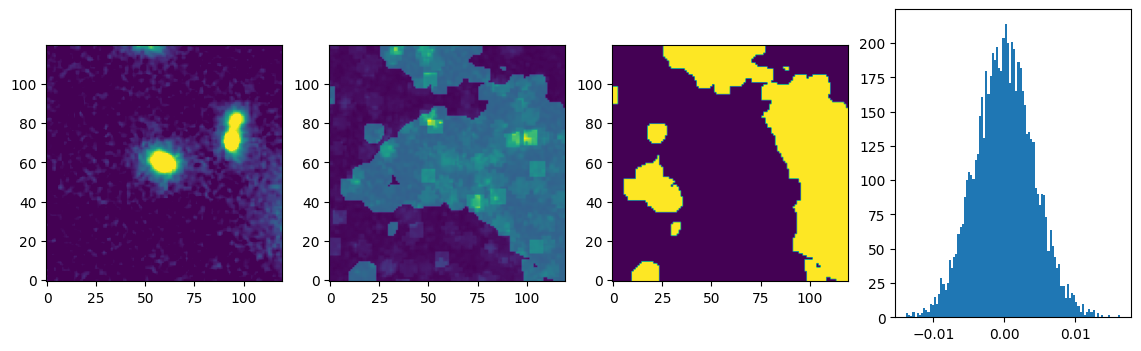

0.33479166666666665


In [7]:
for img_path in img_path_list[::-1]:
    with fits.open(img_path) as hdul:
        sci_cut = Cutout2D(hdul['SCI_BKSUB'].data, (x_c, y_c), (2*size,2*size)).data
        w = WCS(hdul['SCI_BKSUB'].header)
        cut = Cutout2D(hdul['SCI_BKSUB'].data, (x_c, y_c), (size*2, size*2), wcs=w)
        sci_cut, w_cut = cut.data, cut.wcs
        err_cut = Cutout2D(hdul['ERR'].data, (x_c, y_c), (size*2, size*2)).data
        
    scimap, errmap, bpmask, data1d = sc.gen_cutout(sci_cut, err_cut, hist=True)
    fig, ax = plt.subplots(1, 4, figsize=(14,4))

    ax[0].imshow(scimap, origin='lower', vmin=np.percentile(scimap[~bpmask], 60), vmax=np.percentile(scimap[~bpmask], 99))
    ax[1].imshow(errmap, origin='lower')
    ax[2].imshow(bpmask, origin='lower')
    ax[3].hist(data1d, bins=100)
    plt.show()
    print(bpmask.sum()/bpmask.size)
    break

In [48]:
if not os.path.exists(sample_dir):
    os.mkdir(sample_dir)
band_list = ['F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F444W']
for img_path,band in zip(img_path_list,band_list):
    with fits.open(img_path) as hdul:
        sci_cut = Cutout2D(hdul['SCI_BKSUB'].data, (x_c, y_c), (2*size,2*size)).data
        w = WCS(hdul['SCI_BKSUB'].header)
        cut = Cutout2D(hdul['SCI_BKSUB'].data, (x_c, y_c), (size*2, size*2), wcs=w)
        sci_cut, w_cut = cut.data, cut.wcs
        err_cut = Cutout2D(hdul['ERR'].data, (x_c, y_c), (size*2, size*2)).data
    scimap, errmap, bpmask = sc.gen_cutout(sci_cut, err_cut)

    sci_path = sample_dir + 'sci_' + band + '.fits'
    hdr_sci = w_cut.to_header()
    hdr_sci['EXTNAME'] = 'SCI_BKSUB'
    hdr_sci['xc'] = x_c
    hdr_sci['yc'] = y_c
    fits.writeto(sci_path, scimap, header=hdr_sci)

    err_path = sample_dir + 'err_' + band + '.fits'
    hdr_err = fits.Header()
    hdr_err['EXTNAME'] = 'ERR'
    hdr_err['xc'] = x_c
    hdr_err['yc'] = y_c
    fits.writeto(err_path, errmap, header=hdr_err)

    err0_path = sample_dir + 'err0_' + band + '.fits'
    hdr_err0 = fits.Header()
    hdr_err0['EXTNAME'] = 'ERR0'
    hdr_err0['xc'] = x_c
    hdr_err0['yc'] = y_c
    fits.writeto(err0_path, err_cut, header=hdr_err0)
            
    bpmask_path = sample_dir + 'bpmask_' + band + '.fits'
    hdr_bpmask = fits.Header()
    hdr_bpmask['EXTNAME'] = 'BPMASK'
    hdr_bpmask['xc'] = x_c
    hdr_bpmask['yc'] = y_c
    fits.writeto(bpmask_path, bpmask.astype(int), header=hdr_bpmask)

Set DATE-AVG to '2022-06-22T00:06:18.287' from MJD-AVG.
Set DATE-END to '2022-06-22T01:14:35.286' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.777916 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725421070.363 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T01:53:47.526' from MJD-AVG.
Set DATE-END to '2022-06-22T02:27:14.386' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.797135 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725520711.998 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T02:59:46.710' from MJD-AVG.
Set DATE-END to '2022-06-22T03:26:17.551' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.807444 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725573761.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T23:30:42.583' from MJD-AVG.
Set DATE-END to '2022-06-22T00:03:43.515' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.777916 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725421070.363 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE